In [1]:
import warnings
from pathlib import Path
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
results_dir = Path("../2.evalzoo/results/")
mertrics_filename = "metrics_level_1_ref"

metrics_columns = {
    "sim_retrieval_average_precision_ref_i_mean_i": "mAP",
    "sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i": "-log(pvalue)",
    "sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i": "-log(qvalue)",
}

metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset\t\t": {
        "same_well_diff_pert": "0e4cd68f",
        "same_pert_diff_well": "ceb5f02a",
        "same_well_same_pert": "34fbd8a4",
    },
    # subset -> correct -> robustMAD -> feature select -> metrics
    "subset->correct\t": {
        "same_well_diff_pert": "82ad004e",
        "same_pert_diff_well": "f5c36cb4",
        "same_well_same_pert": "d66f1bce",
    },
    # correct -> robustMAD -> feature select -> subset -> metrics
    "correct->subset\t": {
        "same_well_diff_pert": "3ec971b2",
        "same_pert_diff_well": "72f94e10",
        "same_well_same_pert": "138739c0",
    },
    
}

groupby_columns = {
    "same_well_diff_pert": ["Metadata_Well"],
    "same_pert_diff_well": ["Metadata_JCP2022"],
    "same_well_same_pert": ["Metadata_Well", "Metadata_JCP2022"],
}


In [3]:
metrics_dfs = []

for subset, configs in metrics.items():
    for config, config_dir in configs.items():
        metric_cols = list(metrics_columns.keys())
        metrics_path = results_dir / config_dir / f"{mertrics_filename}.parquet"
        metrics_df = pd.read_parquet(metrics_path, columns=metric_cols + groupby_columns[config])
        metrics_df = metrics_df.groupby(groupby_columns[config])[metric_cols].mean().reset_index()
        metrics_df.drop(groupby_columns[config], axis=1, inplace=True)
        metrics_df.rename(columns=metrics_columns, inplace=True)
        metrics_df["config"] = config
        metrics_df["subset"] = subset.split("\t")[0]
        metrics_df["p<0.05"] = metrics_df["-log(pvalue)"] > 1.3
        metrics_dfs.append(metrics_df)

In [4]:
metrics_df = pd.concat(metrics_dfs, axis=0)
metrics_df.shape

(12174, 6)

In [5]:
metrics_df[metrics_df.config=="same_pert_diff_well"]

,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05
0,0.008561,0.332981,0.002441,same_pert_diff_well,subset,False
1,0.016819,0.679641,0.002441,same_pert_diff_well,subset,False
2,0.005463,0.094635,0.002441,same_pert_diff_well,subset,False
3,0.008892,0.263619,0.002441,same_pert_diff_well,subset,False
4,0.008331,0.306384,0.002441,same_pert_diff_well,subset,False
...,...,...,...,...,...,...
32,0.005406,0.117876,0.000000,same_pert_diff_well,correct->subset,False
33,0.005805,0.148567,0.000000,same_pert_diff_well,correct->subset,False
34,0.010766,0.419729,0.000000,same_pert_diff_well,correct->subset,False
35,0.008413,0.332132,0.000000,same_pert_diff_well,correct->subset,False


same_well_diff_pert subset mmAP: 0.0634 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->correct mmAP: 0.0594 p<0.05: 0.0353 (13/368)
same_well_diff_pert correct->subset mmAP: 0.0978 p<0.05: 0.166 (61/368)


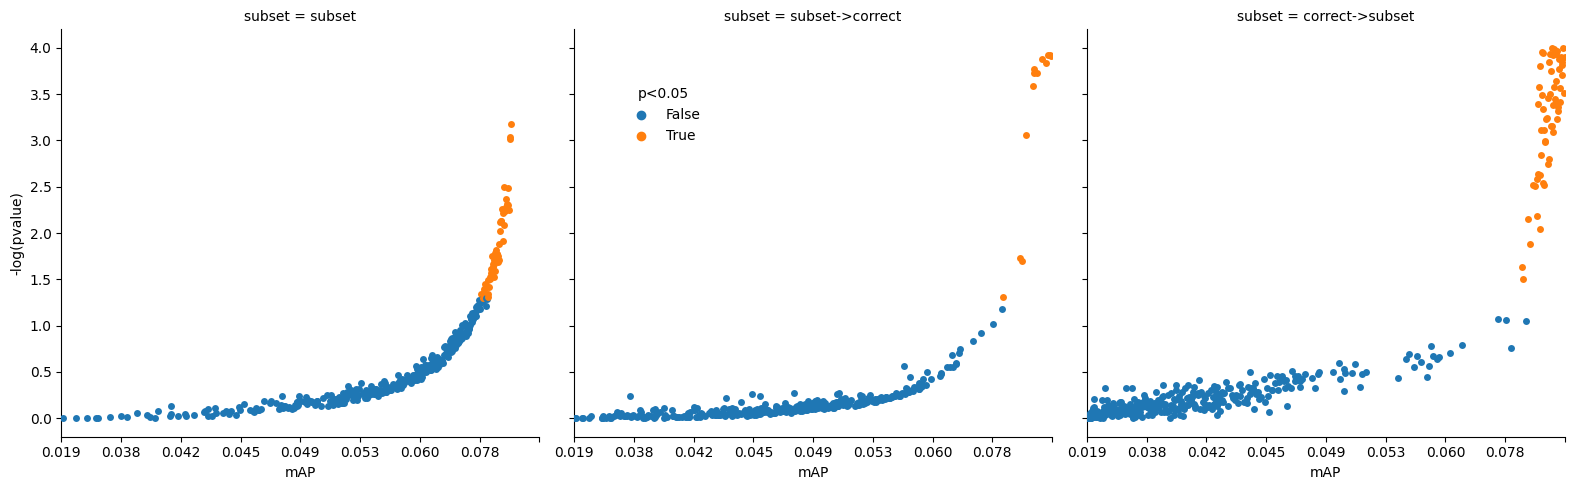

same_pert_diff_well subset mmAP: 0.00961 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->correct mmAP: 0.0135 p<0.05: 0.0 (0/37)
same_pert_diff_well correct->subset mmAP: 0.0102 p<0.05: 0.027 (1/37)


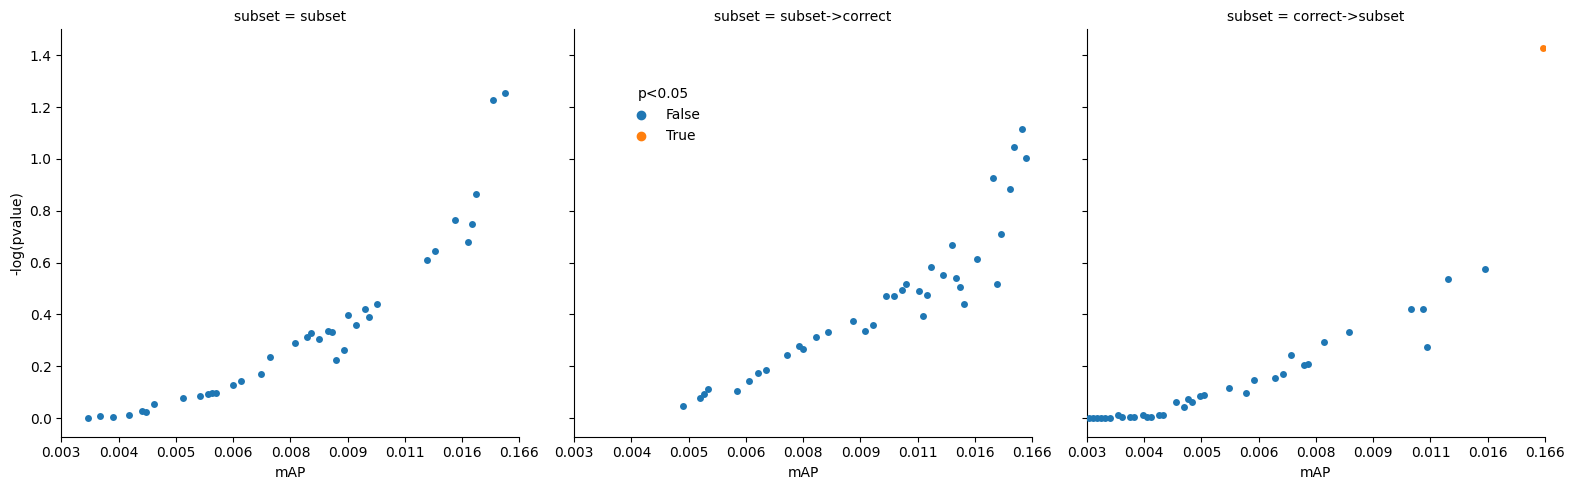

same_well_same_pert subset mmAP: 0.197 p<0.05: 0.902 (3295/3653)
same_well_same_pert subset->correct mmAP: 0.165 p<0.05: 0.775 (2831/3653)
same_well_same_pert correct->subset mmAP: 0.243 p<0.05: 0.684 (2499/3653)


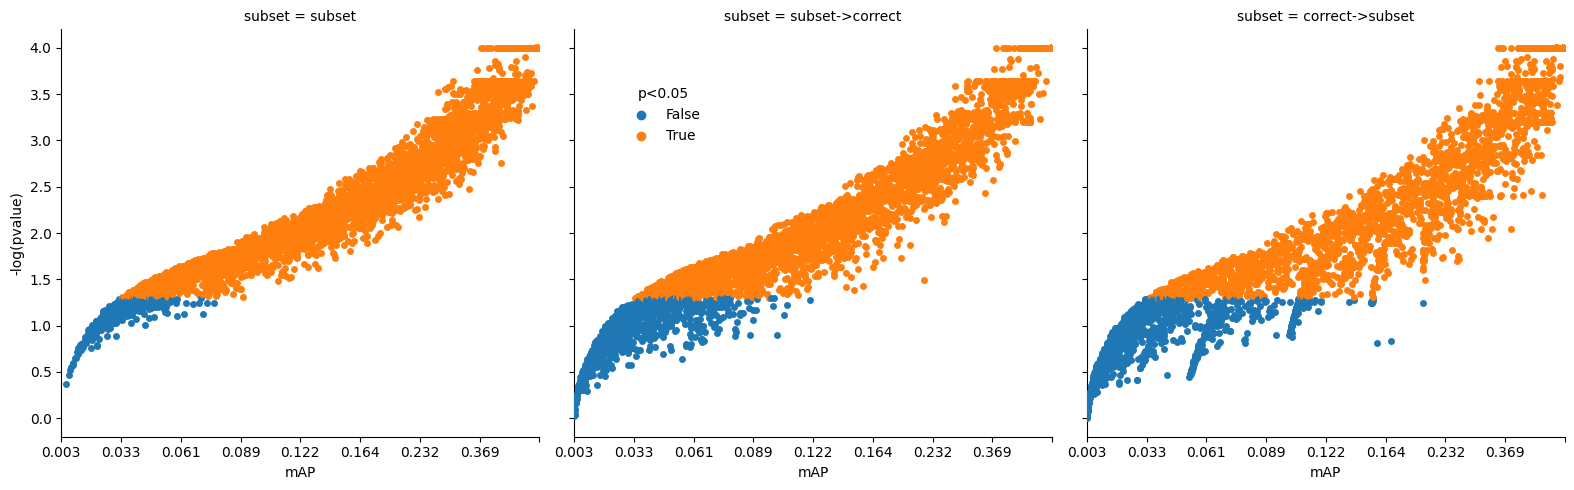

In [6]:
def fmt(s):
    try:
        n = f"{float(s):.3f}"
    except:
        n = ""
    return n

for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    for subset in config_df.subset.unique():
        p_value = config_df[config_df.subset==subset]['p<0.05']
        print(
            config,
            subset,
            f"mmAP: {config_df[config_df.subset==subset].mAP.mean():.03}",
            f"p<0.05: {p_value.mean():.03} ({p_value.sum()}/{p_value.shape[0]})",
            )
    g = sns.catplot(data=config_df, x="mAP", y="-log(pvalue)", col="subset", hue="p<0.05", jitter=False, legend_out=False)
    g._legend.set_bbox_to_anchor((.45, .75))
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(ticker.LinearLocator(9))
        ax.set_xticklabels([fmt(label.get_text()) for label in ax.get_xticklabels()])
        # axes.set_xlim(0.0, 1.0)
    plt.tight_layout()
    plt.show()